In [ ]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [ ]:
df = pd.read_csv("ml-latest-small/ratings.csv")

In [ ]:
df.info() # basically show schema

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [ ]:
df.userId.nunique()

610

In [ ]:
df.movieId.nunique()

9724

In [ ]:
df.rating.value_counts() #check value distribution

4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: rating, dtype: int64

#### Training Dataset Class Wrapper

In [ ]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
    # len(movie_dataset)
    def __len__(self):
        return len(self.users)
    # movie_dataset[1] 
    def __getitem__(self, item):

        users = self.users[item] 
        movies = self.movies[item]
        ratings = self.ratings[item]
        
        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.float32),
        }

#### Create the model

In [ ]:
class RecSysModel(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        # trainable lookup matrix for shallow embedding vectors
        
        self.user_embed = nn.Embedding(n_users, 32)
        self.movie_embed = nn.Embedding(n_movies, 32)
        # user, movie embedding concat
        self.out = nn.Linear(64, 1)

    
    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)
        
        output = self.out(output)
        
        return output

In [ ]:
# encode the user and movie id to start from 0 so we don't run into index out of bound with Embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()
df.userId = lbl_user.fit_transform(df.userId.values)
df.movieId = lbl_movie.fit_transform(df.movieId.values)

df_train, df_valid = model_selection.train_test_split(
    df, test_size=0.2, random_state=42, stratify=df.userId.values
)

train_dataset = MovieDataset(
    users=df_train.userId.values,
    movies=df_train.movieId.values,
    ratings=df_train.rating.values
)

valid_dataset = MovieDataset(
    users=df_valid.userId.values,
    movies=df_valid.movieId.values,
    ratings=df_valid.rating.values
)



In [ ]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 

validation_loader = DataLoader(dataset=valid_dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2) 

dataiter = iter(train_loader)
dataloader_data = next(dataiter)
print(dataloader_data)

{'users': tensor([219, 480, 377, 231]), 'movies': tensor([ 659, 1275,  510, 5966]), 'ratings': tensor([5.0000, 3.0000, 4.5000, 3.0000])}


In [ ]:
model = RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer = torch.optim.Adam(model.parameters())  
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

loss_func = nn.MSELoss()

In [ ]:
print(len(lbl_user.classes_))
print(len(lbl_movie.classes_))
print(df.movieId.max())
print(len(train_dataset))

610
9724
9723
80668


#### Manually run a forward path

In [ ]:
print(dataloader_data['users'])

print(dataloader_data['users'].size())
print(dataloader_data['movies'] )
print(dataloader_data['movies'].size())

user_embed = nn.Embedding(len(lbl_user.classes_), 32)
movie_embed = nn.Embedding(len(lbl_movie.classes_), 32)

out = nn.Linear(64, 1)


tensor([219, 480, 377, 231])
torch.Size([4])
tensor([ 659, 1275,  510, 5966])
torch.Size([4])


In [ ]:
user_embeds = user_embed(dataloader_data['users'])
movie_embeds = movie_embed(dataloader_data['movies'])
print(f"user_embeds {user_embeds.size()}")
print(f"user_embeds {user_embeds}")
print(f"movie_embeds {movie_embeds.size()}")
print(f"movie_embeds {movie_embeds}")

user_embeds torch.Size([4, 32])
user_embeds tensor([[ 0.1461,  1.2940, -0.1859,  0.2387, -0.2722, -0.1550, -0.9184, -1.4596,
         -0.6427,  0.1936, -1.0130,  0.0753, -0.1440,  0.1466,  0.2708,  0.3048,
         -0.1539,  1.2474, -0.7845, -0.8361,  1.0661, -0.1796, -0.8159,  0.3784,
          1.4017,  0.7837, -0.6550,  0.5508, -0.6247, -0.3089,  1.7057, -0.2612],
        [-1.6036, -1.8441, -0.2739,  0.4707,  0.0173, -0.6192,  0.4521,  0.9817,
          2.0183, -0.1737, -0.2424, -0.7031, -1.0800,  0.7481,  0.5334,  0.2074,
         -1.0573, -0.3296, -1.8319,  1.4085,  1.1649, -1.0441, -1.1537,  0.2793,
          0.6358, -0.3817,  0.8335, -0.7293,  0.4988, -2.2762,  0.1980, -0.1985],
        [ 2.5964,  0.5860,  0.8091,  0.4604,  0.1563, -1.1522,  0.3860,  0.0690,
         -0.3059, -0.5412,  1.5848, -1.0827,  1.0802, -0.4552,  0.1648, -0.2961,
          1.3274,  0.9137,  0.6476,  0.9022, -1.5271, -1.1863,  0.2525,  1.4725,
         -0.5598,  1.6689,  1.3840,  0.0195, -0.0257,  0.6283, 

In [ ]:
output = torch.cat([user_embeds, movie_embeds], dim=1) 
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output)
print(f"output: {output}")

output: torch.Size([4, 64])
output: tensor([[ 0.1461,  1.2940, -0.1859,  0.2387, -0.2722, -0.1550, -0.9184, -1.4596,
         -0.6427,  0.1936, -1.0130,  0.0753, -0.1440,  0.1466,  0.2708,  0.3048,
         -0.1539,  1.2474, -0.7845, -0.8361,  1.0661, -0.1796, -0.8159,  0.3784,
          1.4017,  0.7837, -0.6550,  0.5508, -0.6247, -0.3089,  1.7057, -0.2612,
         -1.0659,  1.4620, -0.1045,  0.1619,  0.2826, -1.3610,  0.4543, -0.4848,
          0.3181, -1.4592, -1.1372,  0.5808, -0.8415,  0.6927,  0.4183,  0.8159,
         -2.0601,  0.3014, -0.5406, -0.9536, -0.0483,  0.3350,  0.6771, -2.0092,
          1.7722, -0.6420,  0.1114, -1.5475, -1.0827,  0.8990,  0.4567, -0.6355],
        [-1.6036, -1.8441, -0.2739,  0.4707,  0.0173, -0.6192,  0.4521,  0.9817,
          2.0183, -0.1737, -0.2424, -0.7031, -1.0800,  0.7481,  0.5334,  0.2074,
         -1.0573, -0.3296, -1.8319,  1.4085,  1.1649, -1.0441, -1.1537,  0.2793,
          0.6358, -0.3817,  0.8335, -0.7293,  0.4988, -2.2762,  0.1980, 

In [ ]:
dataloader_data = {k: v.to(device) for k, v in dataloader_data.items()}
with torch.no_grad():
    model_output = model(dataloader_data['users'], 
                   dataloader_data["movies"])

    print(f"model_output: {model_output}, size: {model_output.size()}")

model_output: tensor([[-0.4386],
        [ 0.1039],
        [-0.8934],
        [ 0.3273]], device='cuda:0'), size: torch.Size([4, 1])


In [ ]:
rating = dataloader_data["ratings"]
print(rating)
print(rating.view(4, -1))
print(model_output)

print(rating.sum())

print(model_output.sum() - rating.sum())

tensor([5.0000, 3.0000, 4.5000, 3.0000], device='cuda:0')
tensor([[5.0000],
        [3.0000],
        [4.5000],
        [3.0000]], device='cuda:0')
tensor([[-0.4386],
        [ 0.1039],
        [-0.8934],
        [ 0.3273]], device='cuda:0')
tensor(15.5000, device='cuda:0')
tensor(-16.4007, device='cuda:0')


#### Run the training loop

In [ ]:
#ratings = ratings.to(device)
output = model(dataloader_data["users"], dataloader_data["movies"])
#output = model(users, movies)
loss = loss_func(output, dataloader_data["ratings"])
#model.to(device)
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = [] 

model.train() 
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        train_data = {k: v.to(device) for k, v in train_data.items()}
        output = model(train_data["users"], 
                       train_data["movies"]
                      ) 
        
        # .view(4, -1) is to reshape the rating to match the shape of model output which is 4x1
        rating = train_data["ratings"].view(4, -1).to(torch.float32)
        #rating = train_data["ratings"].view(4, -1).to(torch.float32).to(device)



        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])
        

        if(step_cnt % plot_steps == 0):
            avg_loss = total_loss/(len(train_data["users"]) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0 # reset total_loss

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 loss at step: 5000 is 0.5441305068224669
epoch 0 loss at step: 10000 is 0.20222899459991603
epoch 0 loss at step: 15000 is 0.10924529338087886
epoch 0 loss at step: 20000 is 0.0829139503760729
epoch 0 loss at step: 25000 is 0.06951361679714173
epoch 0 loss at step: 30000 is 0.0654254962853156
epoch 0 loss at step: 35000 is 0.06110092221368104
epoch 0 loss at step: 40000 is 0.06009319938877598
epoch 0 loss at step: 45000 is 0.05709599266587757
epoch 0 loss at step: 50000 is 0.05495677679404616
epoch 0 loss at step: 55000 is 0.055264111757138745
epoch 0 loss at step: 60000 is 0.05350509458627785
epoch 0 loss at step: 65000 is 0.05202468297602609
epoch 0 loss at step: 70000 is 0.05311766450274736
epoch 0 loss at step: 75000 is 0.05215530327446759
epoch 0 loss at step: 80000 is 0.05169754170095548


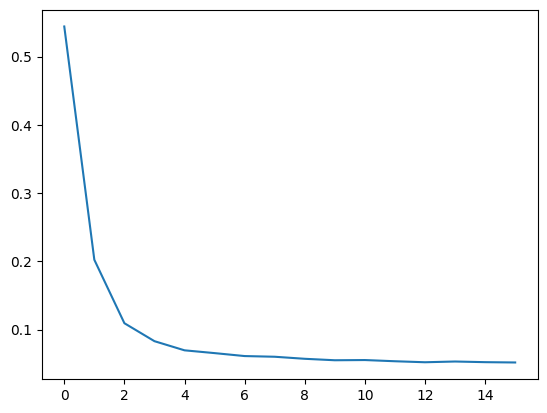

In [ ]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

##### Evaluation with RMSE


In [ ]:
#model.to(device)
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
  
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users'].to(device)
        movies = batched_data['movies'].to(device)
        model_output = model(users, movies)
        #model_output = model(batched_data['users'], 
                       #batched_data["movies"])
        
        model_output_list.append(model_output.sum().item() / len(batched_data['users']) )

        target_rating = batched_data["ratings"]
        
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))

        print(f"model_output: {model_output}, target_rating: {target_rating}")

mae = mean_absolute_error(target_rating_list, model_output_list)
print(f"MAE: {mae}")
# squared If True returns MSE value, if False returns RMSE value.
rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"RMSE: {rms}")

Streaming output truncated to the last 5000 lines.
        [3.8927],
        [3.3357]], device='cuda:0'), target_rating: tensor([2.0000, 5.0000, 4.5000, 3.5000])
model_output: tensor([[3.8369],
        [3.1424],
        [3.3904],
        [3.8158]], device='cuda:0'), target_rating: tensor([3., 3., 3., 3.])
model_output: tensor([[3.5831],
        [3.2561],
        [3.9407],
        [3.0093]], device='cuda:0'), target_rating: tensor([3.5000, 5.0000, 4.5000, 3.0000])
model_output: tensor([[4.3666],
        [3.6332],
        [3.4465],
        [3.3844]], device='cuda:0'), target_rating: tensor([5.0000, 5.0000, 2.5000, 3.5000])
model_output: tensor([[3.4772],
        [4.6605],
        [4.0543],
        [2.9247]], device='cuda:0'), target_rating: tensor([3.0000, 5.0000, 4.0000, 3.5000])
model_output: tensor([[3.3920],
        [3.1934],
        [2.6751],
        [4.1827]], device='cuda:0'), target_rating: tensor([3.0000, 3.5000, 3.5000, 0.5000])
model_output: tensor([[3.5876],
        [3.7037],

##### Evaluation with Recall, Precision, F1-score, NDCG


In [ ]:
from collections import defaultdict

# a dict that stores a list of predicted rating and actual rating pair for each user 
user_est_true = defaultdict(list)
user_dict=defaultdict(list)
# iterate through the validation data to build the user-> [(y1, y1_hat), (y2, y2_hat)...]   
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader): 
        users = batched_data['users'].to(device)
        movies = batched_data['movies'].to(device)
        ratings = batched_data['ratings'].to(device)
        
        #model_output = model(batched_data['users'], batched_data["movies"])
        model_output = model(users, movies)

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item() 
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()
            
            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))   
            user_dict[user_id].append((pred_rating, true_rating,movie_id))         


Streaming output truncated to the last 5000 lines.
248, 2102, 3.838106155395508, 4.0
155, 1439, 3.2874083518981934, 3.0
413, 4816, 3.3533291816711426, 4.0
560, 4419, 3.457336187362671, 3.0
287, 3827, 3.2628633975982666, 3.5
266, 1487, 3.855757474899292, 4.0
562, 8413, 3.781885862350464, 3.5
559, 4112, 3.5972213745117188, 3.5
508, 4930, 3.149686336517334, 2.5
609, 9372, 3.717951536178589, 3.5
566, 5192, 1.8228490352630615, 5.0
56, 902, 3.859715461730957, 5.0
297, 1156, 2.258018970489502, 2.0
386, 4498, 3.5444095134735107, 4.5
350, 7629, 3.5762076377868652, 4.5
67, 2345, 3.090043306350708, 3.0
479, 921, 3.5231738090515137, 5.0
226, 602, 4.681661605834961, 4.5
18, 649, 2.635730266571045, 4.0
110, 7396, 3.5867366790771484, 3.5
124, 3468, 3.9133377075195312, 4.0
211, 6997, 3.6151466369628906, 3.5
468, 46, 4.066888809204102, 4.0
413, 4123, 3.0881872177124023, 2.5
419, 2799, 3.3584976196289062, 3.0
583, 275, 3.4811086654663086, 3.0
67, 1318, 3.191847801208496, 4.0
194, 2144, 4.0992431640625, 

In [ ]:
user_est_true

defaultdict(list,
            {273: [(3.144002914428711, 3.5),
              (3.176715135574341, 3.5),
              (2.8507206439971924, 3.0),
              (3.1193654537200928, 3.5),
              (3.0040740966796875, 2.5),
              (2.9696741104125977, 4.0),
              (2.8342630863189697, 3.0),
              (3.3855373859405518, 4.0),
              (3.1518263816833496, 3.5),
              (3.5844478607177734, 4.0),
              (2.9084322452545166, 3.0),
              (3.3705520629882812, 3.0),
              (2.7572803497314453, 3.0),
              (3.296998977661133, 2.5),
              (2.8948488235473633, 2.5),
              (3.368680953979492, 4.0),
              (3.0537452697753906, 3.5),
              (2.935027599334717, 3.5),
              (3.6449170112609863, 4.5),
              (3.154230833053589, 4.0),
              (2.9083235263824463, 3.0),
              (2.808105945587158, 3.0),
              (3.588792562484741, 3.0),
              (3.035797595977783, 3.0),
  

In [ ]:
import math
with torch.no_grad():
    precisions = dict()
    recalls = dict()
    f1_scores = dict()
    ndcgs = dict()
    

    k=10
    threshold=3.5

    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value. 
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # get the number of actual relevant item
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # get the number of recommended item that are predicted relevent and within topk
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # get the number of recommented item that' is also actually relevant within topk
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        print(f"uid {uid},  n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_rec_k}")

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

        # F1 score
        f1_scores[uid] = (2*precisions[uid]*recalls[uid])/(precisions[uid]+recalls[uid]) if (precisions[uid]+recalls[uid]) !=0 else 0

    # NDCG
        idcg = sum((1 / math.log(i+2, 2)) for i in range(k))
        dcg = sum(((est >= threshold) and (true_r >= threshold)) / math.log(i+2, 2) 
        for i, (est, true_r) in enumerate(user_ratings[:k]))
        ndcgs[uid] = dcg / idcg if idcg != 0 else 0



uid 273,  n_rel 157, n_rec_k 10, n_rel_and_rec_k 7
uid 447,  n_rel 138, n_rec_k 3, n_rel_and_rec_k 3
uid 220,  n_rel 55, n_rec_k 10, n_rel_and_rec_k 9
uid 516,  n_rel 19, n_rec_k 0, n_rel_and_rec_k 0
uid 420,  n_rel 5, n_rec_k 6, n_rel_and_rec_k 4
uid 3,  n_rel 23, n_rec_k 10, n_rel_and_rec_k 4
uid 245,  n_rel 38, n_rec_k 10, n_rel_and_rec_k 9
uid 333,  n_rel 16, n_rec_k 10, n_rel_and_rec_k 6
uid 413,  n_rel 288, n_rec_k 10, n_rel_and_rec_k 9
uid 473,  n_rel 290, n_rec_k 10, n_rel_and_rec_k 8
uid 437,  n_rel 69, n_rec_k 10, n_rel_and_rec_k 9
uid 287,  n_rel 75, n_rec_k 10, n_rel_and_rec_k 8
uid 609,  n_rel 184, n_rec_k 10, n_rel_and_rec_k 10
uid 291,  n_rel 55, n_rec_k 10, n_rel_and_rec_k 7
uid 62,  n_rel 36, n_rec_k 10, n_rel_and_rec_k 8
uid 379,  n_rel 146, n_rec_k 10, n_rel_and_rec_k 8
uid 110,  n_rel 77, n_rec_k 10, n_rel_and_rec_k 8
uid 482,  n_rel 100, n_rec_k 10, n_rel_and_rec_k 7
uid 479,  n_rel 91, n_rec_k 10, n_rel_and_rec_k 9
uid 524,  n_rel 76, n_rec_k 10, n_rel_and_rec_k 1

In [ ]:
# Precision and recall can then be averaged over all users
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")

print(f"recall @ {k} : {sum(rec for rec in recalls.values()) / len(recalls)}")

print(f"F1 score @ {k} : {sum(f1 for f1 in f1_scores.values()) / len(f1_scores)}")

print(f"NDCG @ {k} : {sum(nd for nd in ndcgs.values()) / len(ndcgs)}")


precision @ 10: 0.6892668488160297
recall @ 10 : 0.4566581804402928
F1 score @ 10 : 0.4920445919549361
NDCG @ 10 : 0.5686252612009304


In [ ]:
'''
import pandas as pd

# load movie data
movies = pd.read_csv('ml-latest-small/movies.csv')

# load user data
#user_dict = {1: [[4, 3.5, 110], [3, 4.5, 300], [5, 2.0, 215], ...], 2: [[1, 2.5, 215], [2, 4.0, 110], [3, 3.0, 300], ...], ...}

# create a function to get movie names by id
def get_movie_name(movie_id):
    movie = movies[movies['movieId'] == movie_id]
    if len(movie) > 0:
        return movie['title'].values[0]
    else:
        return ""

# iterate through each user in user_dict
for user_id, ratings in user_dict.items():
    print(f"Top 10 movie recommendations for user {user_id}:")
    # sort the ratings in descending order of predicted rating and take top 10
    top_rated_movies = sorted(ratings, key=lambda x: x[1], reverse=True)[:10]
    # iterate through top 10 rated movies and print movie name and predicted rating
    for rating in top_rated_movies:
        movie_id = rating[2]
        movie_name = get_movie_name(movie_id)
        predicted_rating = rating[1]
        print(f"\t{movie_name} (predicted rating: {predicted_rating:.2f})")
    print("\n")

'''

Streaming output truncated to the last 5000 lines.
	 (predicted rating: 1.00)


Top 10 movie recommendations for user 285:
	Restoration (1995) (predicted rating: 5.00)
	Rawhead Rex (1986) (predicted rating: 5.00)
	Afterglow (1997) (predicted rating: 5.00)
	 (predicted rating: 4.50)
	No Small Affair (1984) (predicted rating: 4.50)
	Lost Weekend, The (1945) (predicted rating: 4.50)
	Three to Tango (1999) (predicted rating: 4.50)
	Grand Day Out with Wallace and Gromit, A (1989) (predicted rating: 4.00)
	Blue in the Face (1995) (predicted rating: 4.00)
	Poetic Justice (1993) (predicted rating: 4.00)


Top 10 movie recommendations for user 288:
	Cutthroat Island (1995) (predicted rating: 4.50)
	North by Northwest (1959) (predicted rating: 4.00)
	Penny Serenade (1941) (predicted rating: 4.00)
	Gone with the Wind (1939) (predicted rating: 3.50)
	Black Hole, The (1979) (predicted rating: 2.50)


Top 10 movie recommendations for user 100:
	 (predicted rating: 5.00)
	 (predicted rating: 4.00)
	L